In [1]:
import numpy as np 
import pandas as pd 
from datetime import datetime
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/usa-data/usa_data.csv
/kaggle/input/covidvaccine-tweets/covidvaccine.csv
/kaggle/input/api-keyy/API_key.txt


In [2]:
# Reading data from the kaggle dataset
data = pd.read_csv("/kaggle/input/covidvaccine-tweets/covidvaccine.csv")
data.head()

/tmp/ipykernel_18/1446635512.py:2: DtypeWarning: Columns (5,6,7,12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/kaggle/input/covidvaccine-tweets/covidvaccine.csv")


user_name              user_location  \
0                 MyNewsNE                      Assam   
1            Shubham Gupta                        NaN   
2  Journal of Infectiology                        NaN   
3                     Zane                        NaN   
4       Ann-Maree O’Connor  Adelaide, South Australia   

                                    user_description      user_created  \
0  MyNewsNE a dedicated multi-lingual media house...  24-05-2020 10:18   
1  I will tell about all experiences of my life f...  14-08-2020 16:42   
2  Journal of Infectiology (ISSN 2689-9981) is ac...  14-12-2017 07:07   
3                                  Fresher than you.  18-09-2019 11:01   
4  Retired university administrator. Melburnian b...  24-01-2013 14:53   

   user_followers user_friends user_favourites user_verified  \
0            64.0         11.0           110.0         False   
1             1.0         17.0             0.0         False   
2           143.0        566.0             8.0         False   
3            29.0         25.0           620.0         False   
4            83.0        497.0         10737.0         False   

               date                                               text  \
0  18-08-2020 12:55  Australia to Manufacture Covid-19 Vaccine and ...   
1  18-08-2020 12:55  #CoronavirusVaccine #CoronaVaccine #CovidVacci...   
2  18-08-2020 12:46  Deaths due to COVID-19 in Affected Countries\n...   
3  18-08-2020 12:45  @Team_Subhashree @subhashreesotwe @iamrajchoco...   
4  18-08-2020 12:45  @michellegrattan @ConversationEDU This is what...   

                                            hashtags               source  \
0                                   ['CovidVaccine']      Twitter Web App   
1  ['CoronavirusVaccine', 'CoronaVaccine', 'Covid...  Twitter for Android   
2                                                NaN      Twitter Web App   
3                                                NaN  Twitter for Android   
4                                                NaN      Twitter Web App   

  is_retweet  
0      False  
1      False  
2      False  
3      False  
4      False

In [3]:
#remove unneeded columns so data is easier to read
data = data.drop(columns=['user_description', 'user_created','user_followers','user_friends','user_favourites','source','is_retweet','user_verified','user_name'])
data['raw_text'] = data['text']
data.head()

user_location              date  \
0                      Assam  18-08-2020 12:55   
1                        NaN  18-08-2020 12:55   
2                        NaN  18-08-2020 12:46   
3                        NaN  18-08-2020 12:45   
4  Adelaide, South Australia  18-08-2020 12:45   

                                                text  \
0  Australia to Manufacture Covid-19 Vaccine and ...   
1  #CoronavirusVaccine #CoronaVaccine #CovidVacci...   
2  Deaths due to COVID-19 in Affected Countries\n...   
3  @Team_Subhashree @subhashreesotwe @iamrajchoco...   
4  @michellegrattan @ConversationEDU This is what...   

                                            hashtags  \
0                                   ['CovidVaccine']   
1  ['CoronavirusVaccine', 'CoronaVaccine', 'Covid...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                            raw_text  
0  Australia to Manufacture Covid-19 Vaccine and ...  
1  #CoronavirusVaccine #CoronaVaccine #CovidVacci...  
2  Deaths due to COVID-19 in Affected Countries\n...  
3  @Team_Subhashree @subhashreesotwe @iamrajchoco...  
4  @michellegrattan @ConversationEDU This is what...

In [4]:
#remove any rows with NaN values 
data = data.dropna()
data.describe()

user_location                 date  \
count             267141               267141   
unique             36286               262678   
top     Bengaluru, India  2021-07-20 13:30:00   
freq               17286                   13   

                                                     text          hashtags  \
count                                              267141            267141   
unique                                             266918            113944   
top     Technically the world’s first #CovidVaccine is...  ['CovidVaccine']   
freq                                                   13             49136   

                                                 raw_text  
count                                              267141  
unique                                             266918  
top     Technically the world’s first #CovidVaccine is...  
freq                                                   13

In [5]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist


# Get the stop words and punkt from nltk
stop_words = set(stopwords.words('english'))

In [6]:
#method to create a bag of words given text
def tokenize(text):
    word_tokens =  word_tokenize(text)
    #Filter the word tokens
    filtered  =  [w for w in word_tokens if not w.lower() in stop_words and w.isalpha()]
    return filtered

In [7]:
#for now, just work with USA location (this list could be expanded)

states = ["Alabama" ,"Alaska" ,"Arizona" ,"Arkansas" ,"California" ,"Colorado" ,"Connecticut" ,"Delaware" ,"Florida" ,"Georgia" ,"Hawaii" ,"Idaho" ,
    "Illinois" ,"Indiana" ,"Iowa" ,"Kansas" ,"Kentucky" ,"Louisiana" ,"Maine" ,"Maryland" ,"Massachusetts" ,"Michigan" ,"Minnesota" ,"Mississippi" ,"Missouri" ,
    "Montana" ,"Nebraska", "Nevada" ,"New Hampshire" ,"New Jersey" ,"New Mexico" ,"New York" ,"North Carolina" ,"North Dakota" ,"Ohio" ,"Oklahoma" ,"Oregon" ,
    "Pennsylvania" ,"Rhode Island" ,"South Carolina" ,"South Dakota" ,"Tennessee" ,"Texas" ,"Utah" ,"Vermont" ,"Virginia" ,"Washington" ,"West Virginia" ,
    "Wisconsin" ,"Wyoming", "USA", "United States", "America", "United States of America", "US" ]

data['user_location'] = data['user_location'].str.lower()
states = [state.lower() for state in states]


#create a dataset which only has the data where the user_location is in the above list

usa_data = data[data['user_location'].isin(states)]
usa_data

user_location                 date  \
46      united states     18-08-2020 03:14   
84      united states     17-08-2020 17:52   
87      massachusetts     17-08-2020 16:42   
208               usa     16-08-2020 18:22   
308     united states     16-08-2020 01:02   
...               ...                  ...   
399506       new york  2022-09-06 19:04:48   
399524       michigan  2022-09-06 17:01:28   
399536  massachusetts  2022-09-06 15:08:23   
399546        alabama  2022-09-06 13:31:14   
399576        florida  2022-09-06 11:39:55   

                                                     text  \
46      Just so we’re clear on how I feel about a #cov...   
84      Just enrolled into a pivotal phase 3 clinical ...   
87      $GERN up 7% today.... It's either going to cur...   
208     #5G the silent killer just like #DirectedEnerg...   
308     Who had this on their 2020 bingo card? #vaccin...   
...                                                   ...   
399506  Many Young Kids With COVID Show No Symptoms of...   
399524  @cvspharmacy: I am honestly not sure how to an...   
399536  @maura_healey How is your investigation into t...   
399546  HUH? #Pfizer’s CEO implies mRNA technology was...   
399576  New vaccines get green light as University of ...   

                                                 hashtags  \
46                                       ['covidvaccine']   
84                                       ['CovidVaccine']   
87                                        ['BloodCancer']   
208     ['5G', 'DirectedEnergyWeapons', 'SmartMeter', ...   
308               ['vaccines', 'COVID19', 'CovidVaccine']   
...                                                   ...   
399506  ['ASYMPTOMATICCOVID', 'CORONAVIRUS', 'COVID', ...   
399524                                   ['CovidVaccine']   
399536  ['BigPharma', 'InformedConsent', 'CovidVaccine...   
399546              ['Pfizer', 'COVID19', 'CovidVaccine']   
399576                        ['COVID19', 'CovidVaccine']   

                                                 raw_text  
46      Just so we’re clear on how I feel about a #cov...  
84      Just enrolled into a pivotal phase 3 clinical ...  
87      $GERN up 7% today.... It's either going to cur...  
208     #5G the silent killer just like #DirectedEnerg...  
308     Who had this on their 2020 bingo card? #vaccin...  
...                                                   ...  
399506  Many Young Kids With COVID Show No Symptoms of...  
399524  @cvspharmacy: I am honestly not sure how to an...  
399536  @maura_healey How is your investigation into t...  
399546  HUH? #Pfizer’s CEO implies mRNA technology was...  
399576  New vaccines get green light as University of ...  

[14196 rows x 5 columns]

In [8]:
usa_data['date'][:196]

46         18-08-2020 03:14
84         17-08-2020 17:52
87         17-08-2020 16:42
208        16-08-2020 18:22
308        16-08-2020 01:02
               ...         
7911       17-09-2020 22:21
7942       17-09-2020 19:03
7975       17-09-2020 14:45
8082       16-09-2020 22:15
8211    2020-09-30 13:44:46
Name: date, Length: 196, dtype: object

In [9]:
# Initialize a new list to store the converted date-only values
date_only_list = []

# Define the transition index where the date format changes
transition_index = 195

# Process the dates with the appropriate format
for idx, date in enumerate(usa_data['date']):
    try:
        if idx < transition_index:
            # Format for the first part
            datetime_object = datetime.strptime(date, '%d-%m-%Y %H:%M')
        else:
            # Format for the second part
            datetime_object = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
        date_only_list.append(datetime_object.date())
    except ValueError as e:
        print(f"Error parsing date {date}: {e}")
        date_only_list.append(None)  # Append None for error cases

# Create a new column in the DataFrame to store the date-only values
usa_data['date_only'] = date_only_list

# Output the updated DataFrame to verify the new column
print(usa_data['date_only'])


46        2020-08-18
84        2020-08-17
87        2020-08-17
208       2020-08-16
308       2020-08-16
             ...    
399506    2022-09-06
399524    2022-09-06
399536    2022-09-06
399546    2022-09-06
399576    2022-09-06
Name: date_only, Length: 14196, dtype: object


/tmp/ipykernel_18/414497964.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usa_data['date_only'] = date_only_list


In [10]:
usa_data

user_location                 date  \
46      united states     18-08-2020 03:14   
84      united states     17-08-2020 17:52   
87      massachusetts     17-08-2020 16:42   
208               usa     16-08-2020 18:22   
308     united states     16-08-2020 01:02   
...               ...                  ...   
399506       new york  2022-09-06 19:04:48   
399524       michigan  2022-09-06 17:01:28   
399536  massachusetts  2022-09-06 15:08:23   
399546        alabama  2022-09-06 13:31:14   
399576        florida  2022-09-06 11:39:55   

                                                     text  \
46      Just so we’re clear on how I feel about a #cov...   
84      Just enrolled into a pivotal phase 3 clinical ...   
87      $GERN up 7% today.... It's either going to cur...   
208     #5G the silent killer just like #DirectedEnerg...   
308     Who had this on their 2020 bingo card? #vaccin...   
...                                                   ...   
399506  Many Young Kids With COVID Show No Symptoms of...   
399524  @cvspharmacy: I am honestly not sure how to an...   
399536  @maura_healey How is your investigation into t...   
399546  HUH? #Pfizer’s CEO implies mRNA technology was...   
399576  New vaccines get green light as University of ...   

                                                 hashtags  \
46                                       ['covidvaccine']   
84                                       ['CovidVaccine']   
87                                        ['BloodCancer']   
208     ['5G', 'DirectedEnergyWeapons', 'SmartMeter', ...   
308               ['vaccines', 'COVID19', 'CovidVaccine']   
...                                                   ...   
399506  ['ASYMPTOMATICCOVID', 'CORONAVIRUS', 'COVID', ...   
399524                                   ['CovidVaccine']   
399536  ['BigPharma', 'InformedConsent', 'CovidVaccine...   
399546              ['Pfizer', 'COVID19', 'CovidVaccine']   
399576                        ['COVID19', 'CovidVaccine']   

                                                 raw_text   date_only  
46      Just so we’re clear on how I feel about a #cov...  2020-08-18  
84      Just enrolled into a pivotal phase 3 clinical ...  2020-08-17  
87      $GERN up 7% today.... It's either going to cur...  2020-08-17  
208     #5G the silent killer just like #DirectedEnerg...  2020-08-16  
308     Who had this on their 2020 bingo card? #vaccin...  2020-08-16  
...                                                   ...         ...  
399506  Many Young Kids With COVID Show No Symptoms of...  2022-09-06  
399524  @cvspharmacy: I am honestly not sure how to an...  2022-09-06  
399536  @maura_healey How is your investigation into t...  2022-09-06  
399546  HUH? #Pfizer’s CEO implies mRNA technology was...  2022-09-06  
399576  New vaccines get green light as University of ...  2022-09-06  

[14196 rows x 6 columns]

In [11]:
def clean_text(text): #from https://www.kaggle.com/code/alankritamishra/covid-19-tweet-sentiment-analysis
#     print(text)
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text 

def clean_text_basic(text):
    text = text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text 


def remove_emoji(text): #from https://www.kaggle.com/code/alankritamishra/covid-19-tweet-sentiment-analysis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text) 

# clean the text, remove emojis, and then tokenize it 
usa_data['clean_text']=usa_data['text'].apply(lambda x: remove_emoji(x))
usa_data['clean_text']=usa_data['text'].apply(lambda x: clean_text_basic(x))
usa_data['text'] = usa_data['text'].apply(lambda x: clean_text(x))
usa_data['text']=usa_data['text'].apply(lambda x: remove_emoji(x))
usa_data['text'] = usa_data['text'].apply(lambda x: tokenize(x))
usa_data.head()

/tmp/ipykernel_18/1672001122.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usa_data['clean_text']=usa_data['text'].apply(lambda x: remove_emoji(x))
/tmp/ipykernel_18/1672001122.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usa_data['clean_text']=usa_data['text'].apply(lambda x: clean_text_basic(x))
/tmp/ipykernel_18/1672001122.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

user_location              date  \
46   united states  18-08-2020 03:14   
84   united states  17-08-2020 17:52   
87   massachusetts  17-08-2020 16:42   
208            usa  16-08-2020 18:22   
308  united states  16-08-2020 01:02   

                                                  text  \
46                         [clear, feel, covidvaccine]   
84   [enrolled, pivotal, phase, clinical, trial, co...   
87   [gern, today, either, going, cure, bloodcancer...   
208  [silent, killer, like, directedenergyweapons, ...   
308              [bingo, card, vaccines, covidvaccine]   

                                              hashtags  \
46                                    ['covidvaccine']   
84                                    ['CovidVaccine']   
87                                     ['BloodCancer']   
208  ['5G', 'DirectedEnergyWeapons', 'SmartMeter', ...   
308            ['vaccines', 'COVID19', 'CovidVaccine']   

                                              raw_text   date_only  \
46   Just so we’re clear on how I feel about a #cov...  2020-08-18   
84   Just enrolled into a pivotal phase 3 clinical ...  2020-08-17   
87   $GERN up 7% today.... It's either going to cur...  2020-08-17   
208  #5G the silent killer just like #DirectedEnerg...  2020-08-16   
308  Who had this on their 2020 bingo card? #vaccin...  2020-08-16   

                                            clean_text  
46   just so we’re clear on how i feel about a #cov...  
84   just enrolled into a pivotal phase  clinical t...  
87   $gern up % today.... it's either going to cure...  
208  # the silent killer just like #directedenergyw...  
308  who had this on their  bingo card? #vaccines #...

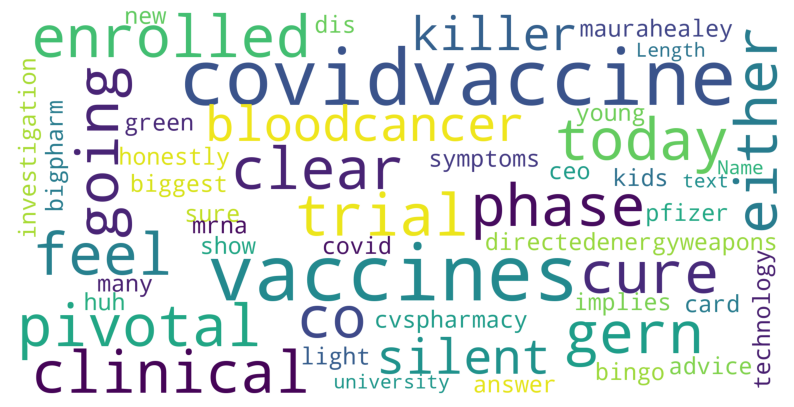

In [12]:
from wordcloud import WordCloud, STOPWORDS

# from https://www.kaggle.com/code/alankritamishra/covid-19-tweet-sentiment-analysis
#make a word cloud of the most common words of the USA data text

word_cloud = WordCloud(
                    background_color='white',
                    stopwords=set(STOPWORDS),
                    max_words=50,
                    max_font_size=40,
                    scale=5,
                    random_state=1).generate(str(usa_data['text']))
fig = plt.figure(1, figsize=(10,10))
plt.axis('off')
fig.subplots_adjust(top=2.3)
plt.imshow(word_cloud)
plt.show()

In [13]:
usa_data.head()

user_location              date  \
46   united states  18-08-2020 03:14   
84   united states  17-08-2020 17:52   
87   massachusetts  17-08-2020 16:42   
208            usa  16-08-2020 18:22   
308  united states  16-08-2020 01:02   

                                                  text  \
46                         [clear, feel, covidvaccine]   
84   [enrolled, pivotal, phase, clinical, trial, co...   
87   [gern, today, either, going, cure, bloodcancer...   
208  [silent, killer, like, directedenergyweapons, ...   
308              [bingo, card, vaccines, covidvaccine]   

                                              hashtags  \
46                                    ['covidvaccine']   
84                                    ['CovidVaccine']   
87                                     ['BloodCancer']   
208  ['5G', 'DirectedEnergyWeapons', 'SmartMeter', ...   
308            ['vaccines', 'COVID19', 'CovidVaccine']   

                                              raw_text   date_only  \
46   Just so we’re clear on how I feel about a #cov...  2020-08-18   
84   Just enrolled into a pivotal phase 3 clinical ...  2020-08-17   
87   $GERN up 7% today.... It's either going to cur...  2020-08-17   
208  #5G the silent killer just like #DirectedEnerg...  2020-08-16   
308  Who had this on their 2020 bingo card? #vaccin...  2020-08-16   

                                            clean_text  
46   just so we’re clear on how i feel about a #cov...  
84   just enrolled into a pivotal phase  clinical t...  
87   $gern up % today.... it's either going to cure...  
208  # the silent killer just like #directedenergyw...  
308  who had this on their  bingo card? #vaccines #...

In [14]:
USA_grouped_data = usa_data.groupby('date_only')
USA_grouped_data.head()

user_location                 date  \
46      united states     18-08-2020 03:14   
84      united states     17-08-2020 17:52   
87      massachusetts     17-08-2020 16:42   
208               usa     16-08-2020 18:22   
308     united states     16-08-2020 01:02   
...               ...                  ...   
399506       new york  2022-09-06 19:04:48   
399524       michigan  2022-09-06 17:01:28   
399536  massachusetts  2022-09-06 15:08:23   
399546        alabama  2022-09-06 13:31:14   
399576        florida  2022-09-06 11:39:55   

                                                     text  \
46                            [clear, feel, covidvaccine]   
84      [enrolled, pivotal, phase, clinical, trial, co...   
87      [gern, today, either, going, cure, bloodcancer...   
208     [silent, killer, like, directedenergyweapons, ...   
308                 [bingo, card, vaccines, covidvaccine]   
...                                                   ...   
399506  [many, young, kids, covid, show, symptoms, dis...   
399524  [cvspharmacy, honestly, sure, answer, advice, ...   
399536  [maurahealey, investigation, biggest, bigpharm...   
399546  [huh, pfizer, ceo, implies, mrna, technology, ...   
399576  [new, vaccines, get, green, light, university,...   

                                                 hashtags  \
46                                       ['covidvaccine']   
84                                       ['CovidVaccine']   
87                                        ['BloodCancer']   
208     ['5G', 'DirectedEnergyWeapons', 'SmartMeter', ...   
308               ['vaccines', 'COVID19', 'CovidVaccine']   
...                                                   ...   
399506  ['ASYMPTOMATICCOVID', 'CORONAVIRUS', 'COVID', ...   
399524                                   ['CovidVaccine']   
399536  ['BigPharma', 'InformedConsent', 'CovidVaccine...   
399546              ['Pfizer', 'COVID19', 'CovidVaccine']   
399576                        ['COVID19', 'CovidVaccine']   

                                                 raw_text   date_only  \
46      Just so we’re clear on how I feel about a #cov...  2020-08-18   
84      Just enrolled into a pivotal phase 3 clinical ...  2020-08-17   
87      $GERN up 7% today.... It's either going to cur...  2020-08-17   
208     #5G the silent killer just like #DirectedEnerg...  2020-08-16   
308     Who had this on their 2020 bingo card? #vaccin...  2020-08-16   
...                                                   ...         ...   
399506  Many Young Kids With COVID Show No Symptoms of...  2022-09-06   
399524  @cvspharmacy: I am honestly not sure how to an...  2022-09-06   
399536  @maura_healey How is your investigation into t...  2022-09-06   
399546  HUH? #Pfizer’s CEO implies mRNA technology was...  2022-09-06   
399576  New vaccines get green light as University of ...  2022-09-06   

                                               clean_text  
46      just so we’re clear on how i feel about a #cov...  
84      just enrolled into a pivotal phase  clinical t...  
87      $gern up % today.... it's either going to cure...  
208     # the silent killer just like #directedenergyw...  
308     who had this on their  bingo card? #vaccines #...  
...                                                   ...  
399506  many young kids with covid show no symptoms of...  
399524  @cvspharmacy: i am honestly not sure how to an...  
399536  @maura_healey how is your investigation into t...  
399546  huh? #pfizer’s ceo implies mrna technology was...  
399576  new vaccines get green light as university of ...  

[2165 rows x 7 columns]

In [15]:
usa_data['date_only'] = pd.to_datetime(usa_data['date_only'])

groups = usa_data.groupby(usa_data['date_only'].dt.year)

# Creating a dictionary of dataframes, with each key representing a year
USA_by_year = {year: group for year, group in groups}

/tmp/ipykernel_18/2529443365.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usa_data['date_only'] = pd.to_datetime(usa_data['date_only'])


In [16]:
#modified from https://www.kaggle.com/code/alankritamishra/covid-19-tweet-sentiment-analysis to be a more general method
def make_word_cloud(dataframe):
    word_cloud = WordCloud(
                        background_color='white',
#                         stopwords=set(STOPWORDS),
                        max_words=50,
                        max_font_size=40,
                        scale=5,
                        random_state=1).generate(str(dataframe['text']))
    fig = plt.figure(1, figsize=(5,5))
    plt.axis('off')
#     plt.title('Date: '+ dataframe['month'].iloc[0], fontsize=30)
    fig.subplots_adjust(top=2.3)
    plt.imshow(word_cloud)
    plt.show()

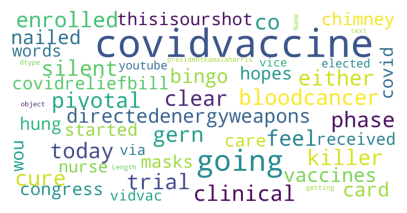

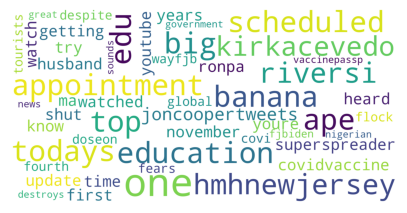

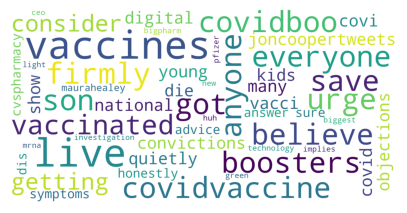

In [17]:
make_word_cloud(USA_by_year[2020])
make_word_cloud(USA_by_year[2021])
make_word_cloud(USA_by_year[2022])

Year: 2020, Month: 8


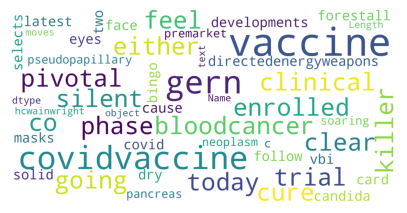

Year: 2020, Month: 9


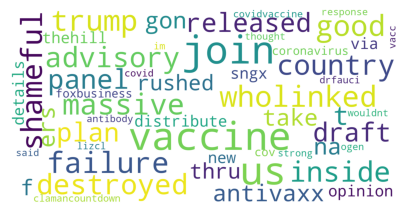

Year: 2020, Month: 10


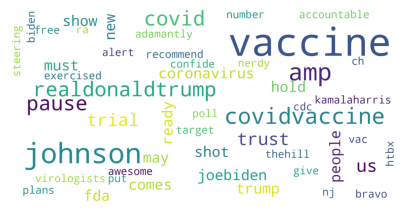

Year: 2020, Month: 11


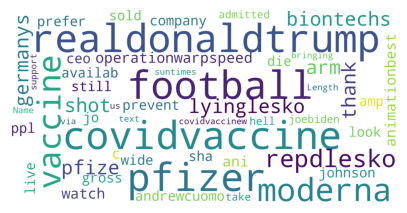

Year: 2020, Month: 12


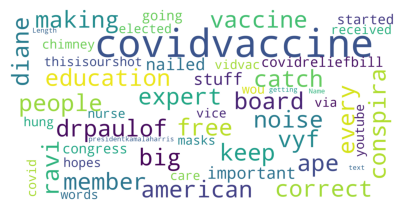

Year: 2021, Month: 1


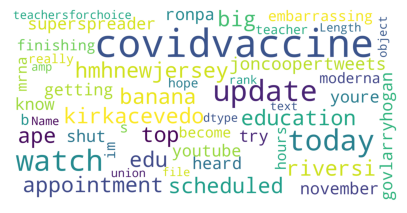

Year: 2021, Month: 2


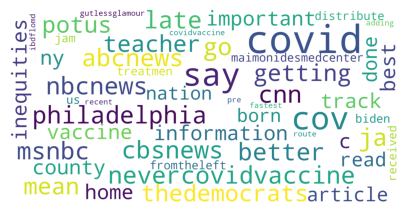

Year: 2021, Month: 3


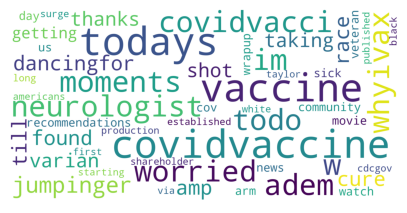

Year: 2021, Month: 4


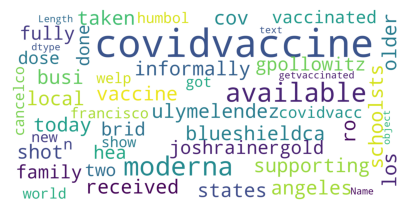

Year: 2021, Month: 5


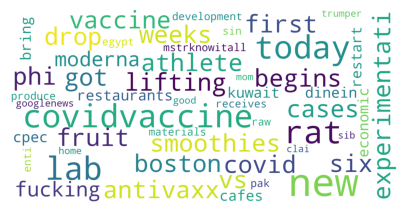

Year: 2021, Month: 6


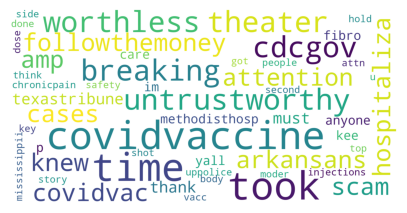

Year: 2021, Month: 7


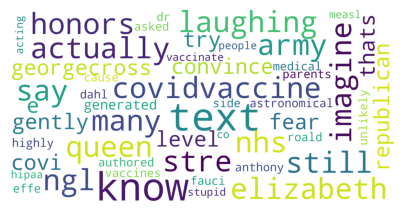

Year: 2021, Month: 8


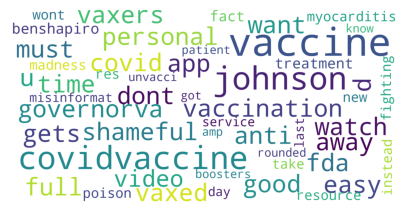

Year: 2021, Month: 9


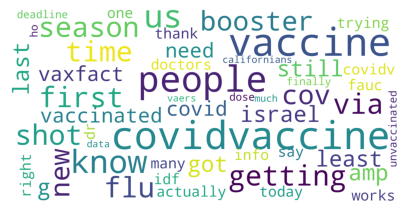

Year: 2021, Month: 10


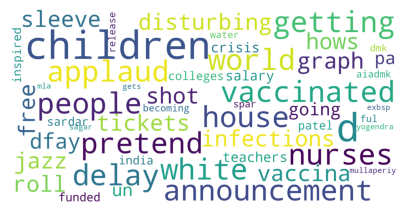

Year: 2021, Month: 11


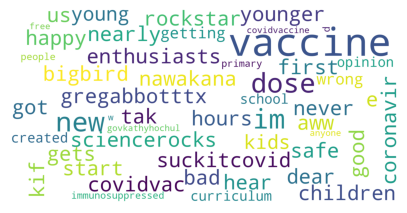

Year: 2021, Month: 12


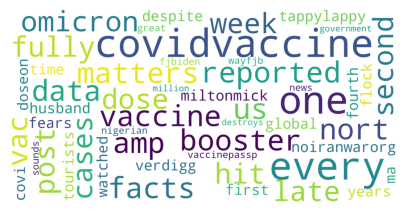

Year: 2022, Month: 1


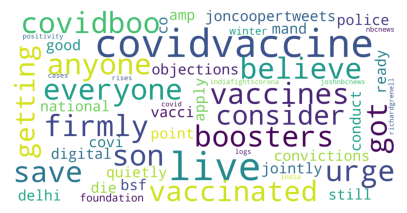

Year: 2022, Month: 2


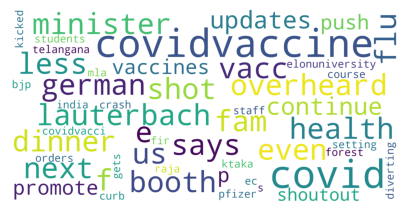

Year: 2022, Month: 3


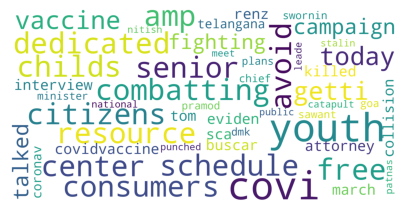

Year: 2022, Month: 4


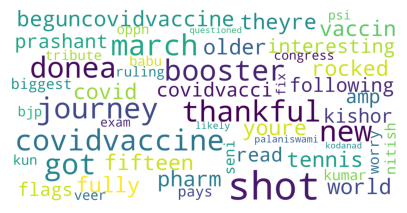

Year: 2022, Month: 5


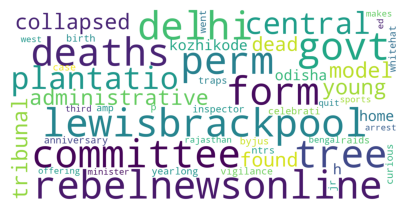

Year: 2022, Month: 6


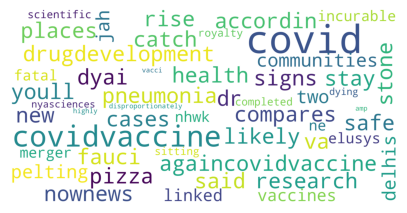

Year: 2022, Month: 7


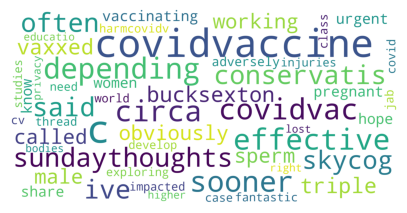

Year: 2022, Month: 8


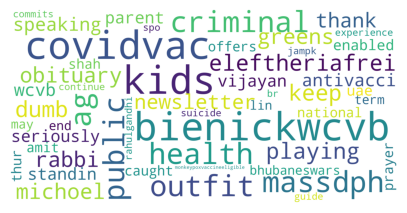

Year: 2022, Month: 9


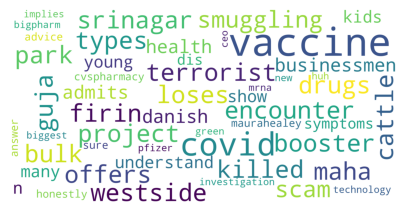

In [18]:
# Grouping by year and month
groups = usa_data.groupby([usa_data['date_only'].dt.year, usa_data['date_only'].dt.month])

# Creating a dictionary of dataframes, with each key representing a year-month combination
dataframes_by_year_month = {(year, month): group for (year, month), group in groups}


for year in range(2020,2023):
    if year == 2020:
        for month in range(8,13):
            print('Year: '+ str(year)+', Month: '+ str(month))
            make_word_cloud(dataframes_by_year_month[(year, month)])
    if year == 2022:
        for month in range(1,10):
            print('Year: '+ str(year)+', Month: '+ str(month))
            make_word_cloud(dataframes_by_year_month[(year, month)])
    if year == 2021:
        for month in range(1,13):
            print('Year: '+ str(year)+', Month: '+ str(month))
            make_word_cloud(dataframes_by_year_month[(year, month)])

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import timedelta

usa_data = usa_data.sort_values('date_only')
# Generate a list of date ranges (adjust start and end dates as needed)
start_date = usa_data['date_only'].min()
end_date = usa_data['date_only'].max()
date_range = pd.date_range(start_date, end_date, freq='MS')

# Function to assign period
def assign_period(date):
    for i in range(len(date_range) - 3):
        if date >= date_range[i] and date < date_range[i + 3]:
            return i
    return None

# Apply the function to create a 'rolling_period' column
usa_data['rolling_period'] = usa_data['date_only'].apply(assign_period)

# Filter out None values if any date was out of the range
usa_data = usa_data[usa_data['rolling_period'].notna()]

# Function to calculate TF-IDF
def calculate_tfidf(dataframe):
    # Ensure that the text data is a string by joining lists into strings
    text_data = dataframe['text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(text_data)
    feature_names = tfidf_vectorizer.get_feature_names_out()
    return pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names, index=dataframe.index)

# Split the dataframe by rolling period and calculate TF-IDF
grouped = usa_data.groupby('rolling_period')
tfidf_dfs = {period: calculate_tfidf(group) for period, group in grouped}

In [20]:
tfidf_dfs

{0.0:        aap  able  absolutely  abus  acceptance  access  accommodate  \
 4067   0.0   0.0         0.0   0.0         0.0     0.0          0.0   
 4066   0.0   0.0         0.0   0.0         0.0     0.0          0.0   
 4053   0.0   0.0         0.0   0.0         0.0     0.0          0.0   
 4037   0.0   0.0         0.0   0.0         0.0     0.0          0.0   
 4034   0.0   0.0         0.0   0.0         0.0     0.0          0.0   
 ...    ...   ...         ...   ...         ...     ...          ...   
 15899  0.0   0.0         0.0   0.0         0.0     0.0          0.0   
 16184  0.0   0.0         0.0   0.0         0.0     0.0          0.0   
 16198  0.0   0.0         0.0   0.0         0.0     0.0          0.0   
 16217  0.0   0.0         0.0   0.0         0.0     0.0          0.0   
 16182  0.0   0.0         0.0   0.0         0.0     0.0          0.0   
 
        accountable  acknowledges  across  ...  yesterday  yet  yikes  york  \
 4067           0.0           0.0     0.0  ...   0

Top TF-IDF Scores:
effectcovidvaccine    1.000000
chance                0.972603
finally               0.968875
get                   0.931367
part                  0.890033
looky                 0.842558
ade                   0.825244
vaccine               0.824772
weeks                 0.812995
schools               0.793484
dtype: float64
Word Cloud for Period 0.0


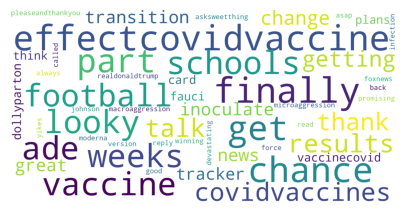

Top TF-IDF Scores:
info          0.977349
done          0.962280
got           0.945184
covid         0.923804
speak         0.875907
resolution    0.867869
vaccine       0.855912
cruising      0.824467
tomorrow      0.814969
vaccinated    0.798235
dtype: float64
Word Cloud for Period 1.0


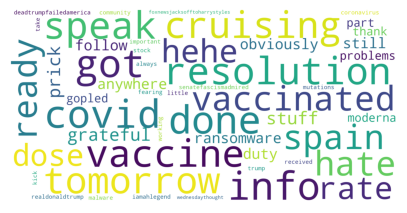

Top TF-IDF Scores:
get                       1.000000
absolutelycovidvaccine    1.000000
share                     1.000000
covidvaccine              1.000000
insanity                  0.982544
surprising                0.982544
maskupamerica             0.982544
lock                      0.982544
true                      0.979033
round                     0.973417
dtype: float64
Word Cloud for Period 2.0


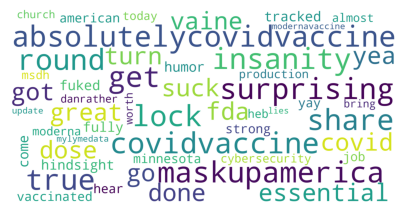

Top TF-IDF Scores:
followed        1.000000
covidvaccine    1.000000
pfizerproud     0.984434
pass            0.984434
progress        0.982672
kills           0.982672
thread          0.981236
thoughts        0.979997
taking          0.973747
please          0.969243
dtype: float64
Word Cloud for Period 3.0


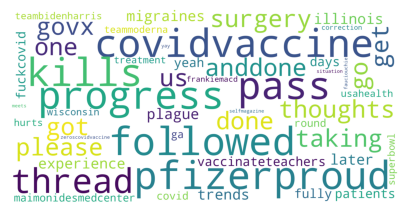

Top TF-IDF Scores:
texascovidvaccine                       1.000000
pokedcanigotoaconcertyetcovidvaccine    1.000000
marylandcovidvaccine                    1.000000
god                                     0.982571
atl                                     0.982571
thing                                   0.974499
line                                    0.974499
scheduled                               0.971176
done                                    0.957008
one                                     0.947930
dtype: float64
Word Cloud for Period 4.0


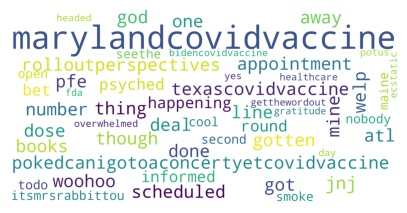

Top TF-IDF Scores:
go                   1.000000
aezs                 0.985669
fuck                 0.985669
please               0.978007
said                 0.976798
done                 0.963395
got                  0.930650
get                  0.927618
latstetter           0.905819
donegetvaccinated    0.891914
dtype: float64
Word Cloud for Period 5.0


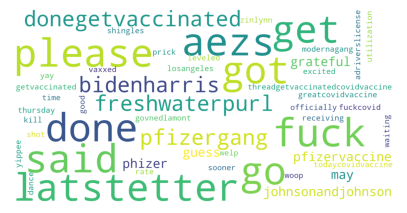

Top TF-IDF Scores:
exactly         0.987587
officially      0.732165
censored        0.724642
good            0.696679
nj              0.682414
concerns        0.679420
obesity         0.679181
finally         0.668535
gt              0.668122
justgenocide    0.657138
dtype: float64
Word Cloud for Period 6.0


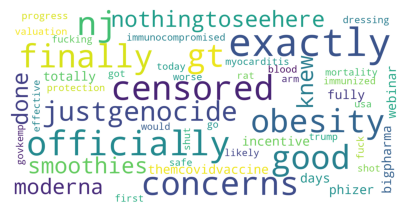

Top TF-IDF Scores:
covered         0.983950
exactly         0.979380
theeliklein     0.803100
done            0.777483
covidvariant    0.730049
question        0.700835
anthropology    0.694435
pfizer          0.678140
cold            0.663911
brain           0.653086
dtype: float64
Word Cloud for Period 7.0


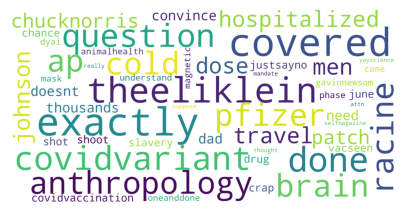

Top TF-IDF Scores:
gold           0.989986
remembering    0.989986
agreed         0.988819
effective      0.981419
take           0.971819
tnceal         0.932027
smart          0.927801
get            0.914589
know           0.907353
idiotscovid    0.898872
dtype: float64
Word Cloud for Period 8.0


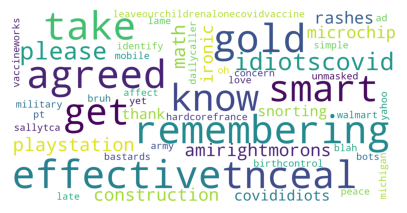

Top TF-IDF Scores:
allcovidisnotover    0.990108
excuses              0.986563
know                 0.971161
leaky                0.939285
get                  0.926212
factsmaskup          0.914595
listen               0.894236
something            0.889022
taking               0.880902
bbc                  0.857660
dtype: float64
Word Cloud for Period 9.0


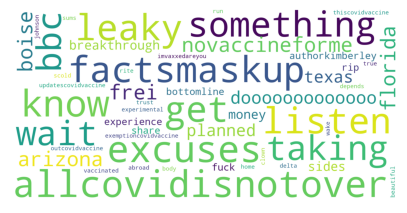

Top TF-IDF Scores:
idf            0.712579
matters        0.667645
season         0.660300
protects       0.540049
host           0.540049
reminder       0.540049
students       0.536874
colorado       0.536874
take           0.528647
inactivated    0.507830
dtype: float64
Word Cloud for Period 10.0


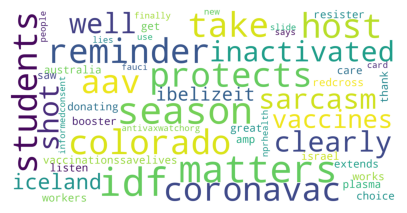

Top TF-IDF Scores:
dose         0.994309
suck         0.987965
boosted      0.986384
finally      0.985067
approved     0.882904
gains        0.824661
hurt         0.820749
political    0.753707
kolkata      0.743907
utah         0.743449
dtype: float64
Word Cloud for Period 11.0


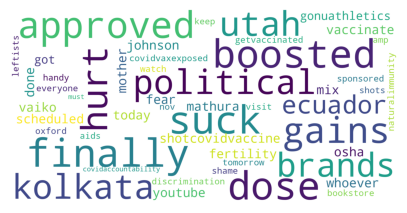

Top TF-IDF Scores:
covidvaccine       1.000000
boosted            0.981326
good               0.975118
goldcoronavirus    0.933689
virus              0.916862
facts              0.902726
dollar             0.883823
explained          0.877225
boost              0.871329
yikes              0.870269
dtype: float64
Word Cloud for Period 12.0


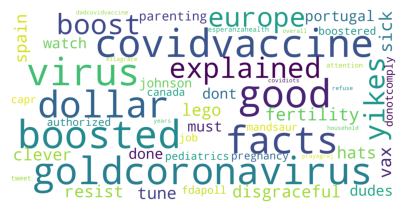

Top TF-IDF Scores:
factcovidvaccine    1.000000
retweet             0.988193
boostered           0.986679
powerful            0.986679
omicronvarient      0.982414
boosted             0.977874
yes                 0.974654
dose                0.902992
walmart             0.870944
shame               0.817429
dtype: float64
Word Cloud for Period 13.0


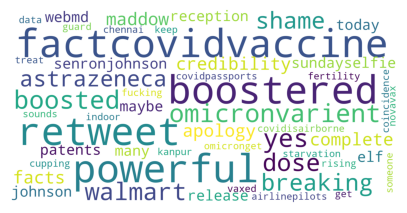

Top TF-IDF Scores:
liescovidvaccine    1.000000
lukewearechange     0.989063
scam                0.985647
gop                 0.894033
safety              0.888046
lab                 0.848467
shingles            0.797469
angelicmommy        0.773643
science             0.758125
medtwitter          0.751037
dtype: float64
Word Cloud for Period 14.0


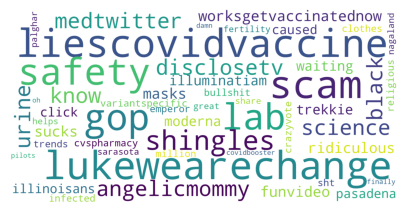

Top TF-IDF Scores:
coursecovidvaccine    1.000000
dissidenteper         0.988026
suicide               0.988026
right                 0.986434
austria               0.985105
death                 0.980113
fatalities            0.834174
ivermectin            0.812355
cv                    0.808861
love                  0.802384
dtype: float64
Word Cloud for Period 15.0


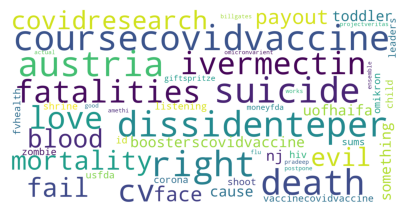

Top TF-IDF Scores:
covidvaccine     1.000000
hear             0.996359
myocarditis      0.718923
deadly           0.684115
puducherry       0.664297
paid             0.619774
shot             0.618603
resume           0.591327
vicepresident    0.581884
party            0.577140
dtype: float64
Word Cloud for Period 16.0


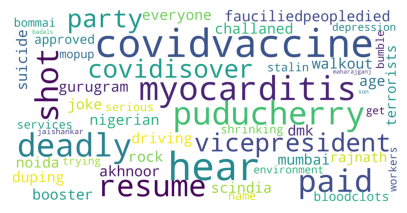

Top TF-IDF Scores:
funny         0.987287
safe          0.809955
shame         0.725102
admit         0.678676
hair          0.655689
terrorists    0.655609
summer        0.645027
paswan        0.627295
got           0.624058
dream         0.619855
dtype: float64
Word Cloud for Period 17.0


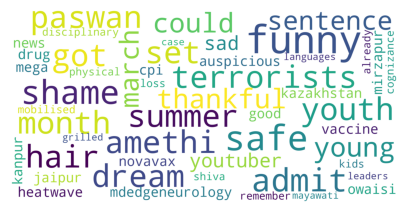

Top TF-IDF Scores:
work         0.980479
killing      0.821183
wonder       0.725998
visa         0.687042
food         0.685607
received     0.676573
varanasi     0.649977
thackeray    0.636771
hepatitis    0.610624
noida        0.586813
dtype: float64
Word Cloud for Period 18.0


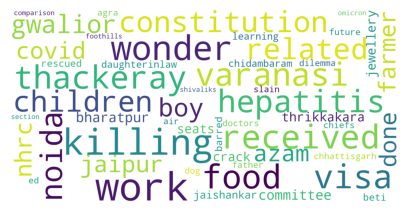

Top TF-IDF Scores:
amyklobuchar    0.745616
choice          0.651357
body            0.630754
srinagar        0.622034
hyderabad       0.614868
kapoor          0.611615
pizza           0.602942
kanpur          0.579545
pharma          0.563782
big             0.563782
dtype: float64
Word Cloud for Period 19.0


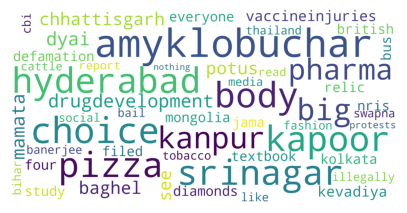

Top TF-IDF Scores:
donate         0.745518
bhuj           0.654409
vaxxed         0.652562
puducherry     0.646934
heal           0.645592
kannauj        0.636054
oath           0.587982
hippocratic    0.587982
patna          0.566425
info           0.565095
dtype: float64
Word Cloud for Period 20.0


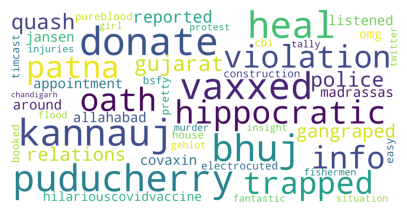

Top TF-IDF Scores:
read                        0.700822
interesting                 0.700822
noida                       0.645263
siblings                    0.590632
coimbatore                  0.576587
hoisted                     0.571063
monkeypoxvaccineeligible    0.560685
novavax                     0.558432
vehicles                    0.553768
ayodhya                     0.550555
dtype: float64
Word Cloud for Period 21.0


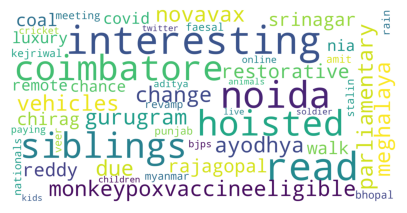

In [21]:
def word_cloud(tfidf_dataframe):
    # Create a dictionary of word frequencies equal to their TF-IDF scores
    word_scores = {word: tfidf_dataframe[word].max() for word in tfidf_dataframe.columns}
    
    # Generate the word cloud using TF-IDF scores as frequencies
    word_cloud = WordCloud(
        background_color='white',
        max_words=50,
        max_font_size=40,
        scale=5,
        random_state=1
    ).generate_from_frequencies(word_scores)
    
    # Display the word cloud
    fig = plt.figure(1, figsize=(5, 5))
    plt.axis('off')
    plt.imshow(word_cloud)
    plt.show()
    
# Function to display the top TF-IDF scores in a DataFrame
def print_tfidf_scores(tfidf_df, top_n=10):
    # Get the maximum TF-IDF scores for each word and sort them
    max_scores = tfidf_df.max().sort_values(ascending=False)
    print("Top TF-IDF Scores:")
    print(max_scores.head(top_n))


for period, tfidf_df in tfidf_dfs.items():
    print_tfidf_scores(tfidf_df, top_n=10)
    print(f"Word Cloud for Period {period}")
    word_cloud(tfidf_df)

# Embeddings

When first getting the embeddings, the following commented-out code was ran. Then, after the embeddings were all calculated, they were added to the dataframe and saved to an external file. This file is then used as an input in the remaining code. By doing this, running this file takes significantly less time as the embeddings don't have to be recalculated.

In [22]:
!pip install openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 11.4 MB/s eta 0:00:00


In [23]:
# usa_data.head()

In [24]:
# from openai import OpenAI

# with open('/kaggle/input/api-keyy/API_key.txt', 'r') as file:
#     # Read the contents of the file
#     api_key = file.read().strip()


# print((api_key))
# api_key = api_key

# client = OpenAI(api_key = api_key)

# def get_embedding(text, model="text-embedding-3-small"):
#     text = text.replace("\n", " ")
#     return client.embeddings.create(input = [text], model=model).data[0].embedding

In [25]:
# print(get_embedding('this is happy'))

In [26]:
# def get_embedding_for_row(row):
#     text = row['clean_text']
#     embedding = get_embedding(text)
#     return embedding

In [27]:
# usa_data['embedding'] = usa_data.apply(get_embedding_for_row, axis=1)

In [28]:
#Save the file with embeddings
# usa_data.to_csv('usa_data.csv',index=False)

**Get Embeddings For Each Day**

In [29]:
usa_data = pd.read_csv('/kaggle/input/usa-data/usa_data.csv')

In [30]:
usa_data.head()

user_location              date  \
0  united states  18-08-2020 03:14   
1  united states  17-08-2020 17:52   
2  massachusetts  17-08-2020 16:42   
3            usa  16-08-2020 18:22   
4  united states  16-08-2020 01:02   

                                                text  \
0                  ['clear', 'feel', 'covidvaccine']   
1  ['enrolled', 'pivotal', 'phase', 'clinical', '...   
2  ['gern', 'today', 'either', 'going', 'cure', '...   
3  ['silent', 'killer', 'like', 'directedenergywe...   
4      ['bingo', 'card', 'vaccines', 'covidvaccine']   

                                            hashtags  \
0                                   ['covidvaccine']   
1                                   ['CovidVaccine']   
2                                    ['BloodCancer']   
3  ['5G', 'DirectedEnergyWeapons', 'SmartMeter', ...   
4            ['vaccines', 'COVID19', 'CovidVaccine']   

                                            raw_text   date_only  \
0  Just so we’re clear on how I feel about a #cov...  2020-08-18   
1  Just enrolled into a pivotal phase 3 clinical ...  2020-08-17   
2  $GERN up 7% today.... It's either going to cur...  2020-08-17   
3  #5G the silent killer just like #DirectedEnerg...  2020-08-16   
4  Who had this on their 2020 bingo card? #vaccin...  2020-08-16   

                                          clean_text  \
0  just so we’re clear on how i feel about a #cov...   
1  just enrolled into a pivotal phase  clinical t...   
2  $gern up % today.... it's either going to cure...   
3  # the silent killer just like #directedenergyw...   
4  who had this on their  bingo card? #vaccines #...   

                                           embedding  
0  [-0.013506374321877956, -0.04608927294611931, ...  
1  [0.005004002712666988, -0.050803299993276596, ...  
2  [0.0024901358410716057, 0.028662126511335373, ...  
3  [0.01767062582075596, 0.03625344857573509, -0....  
4  [-0.015944167971611023, -0.030504394322633743,...

In [31]:
usa_data['embeddings'] = usa_data['embedding'].apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))

# Group by date and calculate the mean of embeddings
average_embeddings_by_day = usa_data.groupby('date_only')['embeddings'].apply(np.mean).reset_index()

/tmp/ipykernel_18/1311385870.py:1: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  usa_data['embeddings'] = usa_data['embedding'].apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))


In [32]:
average_embeddings_by_day

date_only               embeddings
0    2020-08-10   [0.023512696148827672]
1    2020-08-11   [-0.02075581788085401]
2    2020-08-12  [-0.018623598784740483]
3    2020-08-13  [0.0010503336961846799]
4    2020-08-14  [-0.004847077885642648]
..          ...                      ...
455  2022-09-10   [0.012764708662871271]
456  2022-09-11   [0.009363113464239766]
457  2022-09-12   [0.013156825702430474]
458  2022-09-13   [0.008197765355968537]
459  2022-09-14   [0.004496180915988849]

[460 rows x 2 columns]

**get embeddings by month**

In [33]:
usa_data['date_only'] = pd.to_datetime(usa_data['date_only'])


usa_data['month'] = usa_data['date_only'].dt.to_period('M')

# Group by month and calculate the mean of embeddings
average_embeddings_monthly = usa_data.groupby('month')['embeddings'].apply(np.mean).reset_index()


In [34]:
average_embeddings_monthly

month                embeddings
0   2020-08   [-0.006734304908987772]
1   2020-09  [-0.0042503800895434644]
2   2020-10    [0.004452242658404198]
3   2020-11   [-0.003343095543859653]
4   2020-12   [-0.007750124874227694]
5   2021-01   [-0.006667237837403122]
6   2021-02   [-0.008317465367579196]
7   2021-03   [-0.009703118741076518]
8   2021-04   [-0.008785508470206684]
9   2021-05  [-0.0009650165487407827]
10  2021-06  [-0.0018769886730841897]
11  2021-07  [-0.0026007044653854235]
12  2021-08  [-0.0009230986110800772]
13  2021-09   [-0.002933782603792941]
14  2021-10   [0.0011280041723091953]
15  2021-11    [0.001820096208339237]
16  2021-12   [0.0006178965864102903]
17  2022-01    [0.002568709753866634]
18  2022-02    [0.005179041912117059]
19  2022-03    [0.007033237815472833]
20  2022-04    [0.010018650117463017]
21  2022-05    [0.008924830910762486]
22  2022-06    [0.004437416756941689]
23  2022-07     [0.00943675694755879]
24  2022-08    [0.013222796321949653]
25  2022-09    [0.011150119337398791]

In [35]:
from scipy.spatial.distance import euclidean

# Calculate distances between all pairs of months
distances = []
months = average_embeddings_monthly['month'].unique()

for i in range(len(months)):
    for j in range(i, len(months)):
        month1 = months[i]
        month2 = months[j]
        
        # Get the embeddings for the two months
        embedding_month1 = average_embeddings_monthly.loc[average_embeddings_monthly['month'] == month1, 'embeddings'].iloc[0]
        embedding_month2 = average_embeddings_monthly.loc[average_embeddings_monthly['month'] == month2, 'embeddings'].iloc[0]
        
        # Calculate Euclidean distance between embeddings
        distance = euclidean(embedding_month1, embedding_month2)
        
        # Store the distances
        distances.append({'Month1': month1, 'Month2': month2, 'Distance': distance})

# Convert the distances to a DataFrame
distances_USA_months = pd.DataFrame(distances)

In [36]:
distances_USA_months

Month1   Month2  Distance
0    2020-08  2020-08  0.000000
1    2020-08  2020-09  0.002484
2    2020-08  2020-10  0.011187
3    2020-08  2020-11  0.003391
4    2020-08  2020-12  0.001016
..       ...      ...       ...
346  2022-07  2022-08  0.003786
347  2022-07  2022-09  0.001713
348  2022-08  2022-08  0.000000
349  2022-08  2022-09  0.002073
350  2022-09  2022-09  0.000000

[351 rows x 3 columns]

In [37]:
pivot_table = pd.pivot_table(distances_USA_months, values='Distance', index='Month1', columns='Month2', fill_value=np.nan)

# Mirror the upper triangle to make the matrix symmetrical
symmetrical_matrix = pivot_table.fillna(pivot_table.T)

# print(symmetrical_matrix)

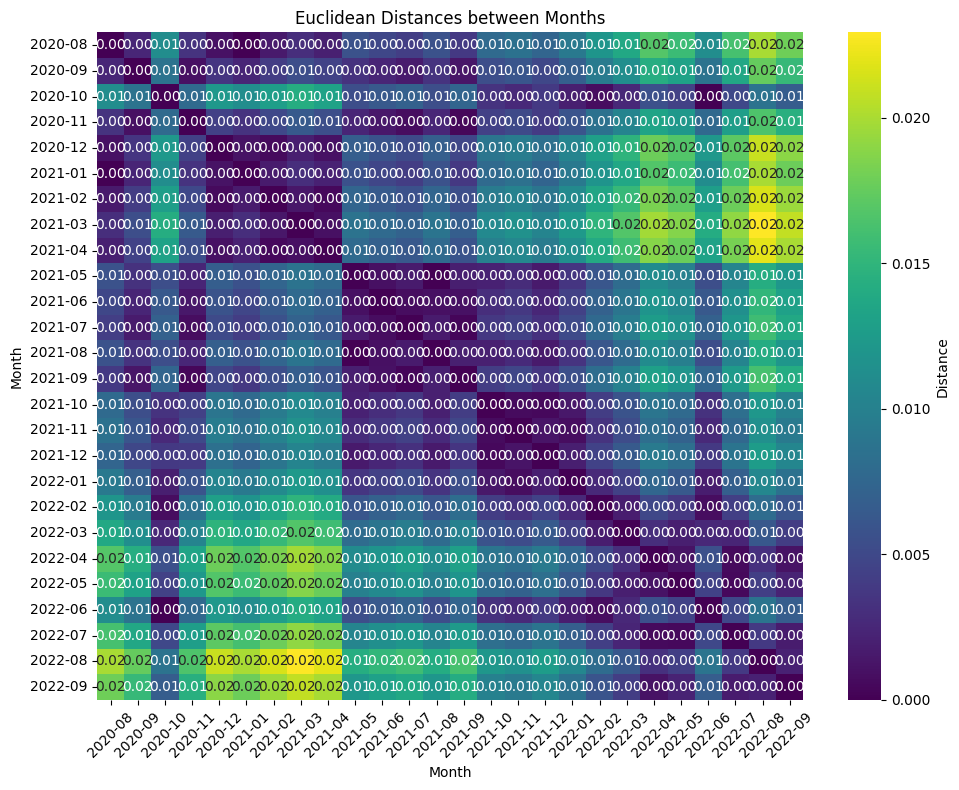

In [38]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(symmetrical_matrix, cmap='viridis', annot=True, fmt=".2f", cbar_kws={'label': 'Distance'})
plt.title('Euclidean Distances between Months')
plt.xlabel('Month')
plt.ylabel('Month')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

The above figure reflects somewhat inacurate distances. Calculating the averages of the embddings using a prebuilt function collapsed the data significantly and instead the average should have been computed for each dimension of the data first and then the euclidean distance could be measured between points in that way. Unfortunatly due to time constaints I was not able to make this edit.

# PCA

In [39]:
# Define a function to parse the string representations into numerical arrays
def parse_embedding(embedding_string):
    # Remove '[' and ',' characters, then split the string by whitespace and convert substrings into floats
    embedding_values = [float(value.strip(',[]')) for value in embedding_string.split()]
    return np.array(embedding_values)

# Apply the parsing function to each element in the 'embedding' column
usa_data['embedding_numeric'] = usa_data['embedding'].apply(parse_embedding)

# Convert the list of numerical arrays into a 2D numerical array
embeddings_array = np.vstack(usa_data['embedding_numeric'])

[0.05090955 0.02948531]


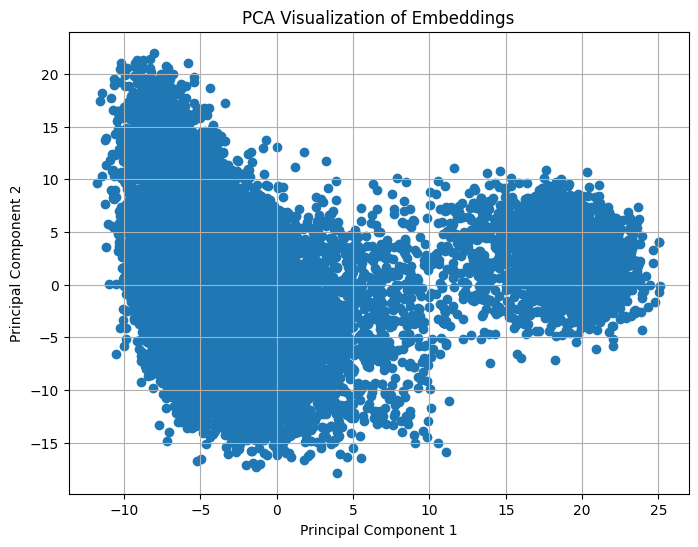

In [40]:
from sklearn.decomposition import PCA

# Step 2: Standardize the data
mean_embedding = embeddings_array.mean(axis=0)
std_embedding = embeddings_array.std(axis=0)
standardized_embeddings = (embeddings_array - mean_embedding) / std_embedding

# Step 3: Perform PCA with the maximum number of components
pca = PCA(n_components=2)

# Fit PCA to the standardized embeddings
pca.fit(standardized_embeddings)
print(pca.explained_variance_ratio_)

# Transform the embeddings to the reduced-dimensional space
embeddings_pca = pca.transform(standardized_embeddings)

# Step 4: Visualize the results
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1])
plt.title('PCA Visualization of Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


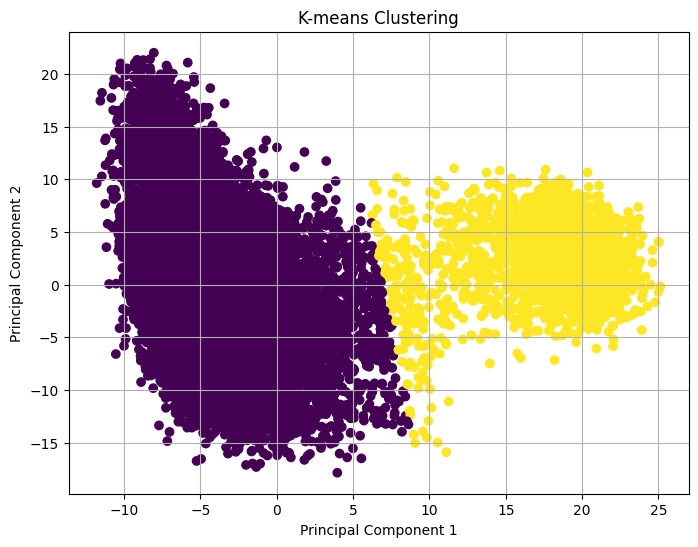

In [41]:
from sklearn.cluster import KMeans

n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(embeddings_pca)

# Get the cluster labels assigned to each data point
cluster_labels = kmeans.labels_

# Visualize the clusters on the PCA scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title('K-means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
# plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

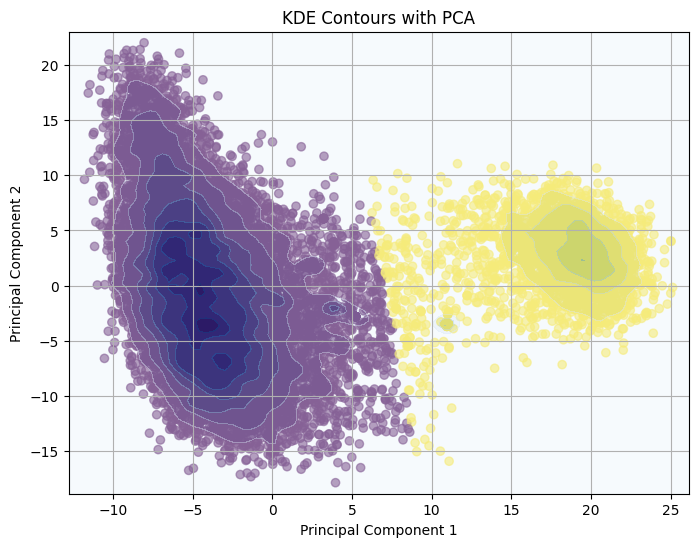

In [42]:
from sklearn.neighbors import KernelDensity

# Fit Kernel Density Estimation (KDE) to the PCA-transformed data
kde = KernelDensity(bandwidth=0.5)  
kde.fit(embeddings_pca)

# Define a grid of points for evaluation
x_min, x_max = embeddings_pca[:, 0].min() - 1, embeddings_pca[:, 0].max() + 1
y_min, y_max = embeddings_pca[:, 1].min() - 1, embeddings_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Evaluate the KDE at each point on the grid
kde_scores = np.exp(kde.score_samples(grid_points))
kde_scores = kde_scores.reshape(xx.shape)

# Visualize the KDE contours overlaid on the PCA scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)
plt.contourf(xx, yy, kde_scores, cmap='Blues', alpha=0.4)  # Adjust contour colors and transparency
plt.title('KDE Contours with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
# plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

In [43]:
import matplotlib as mpl
cmap = mpl.cm.get_cmap('inferno')
rgba = cmap(0.5)
rgba

/tmp/ipykernel_18/634865272.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('inferno')


(0.735683, 0.215906, 0.330245, 1.0)

In [44]:
cmap(0)

(0.001462, 0.000466, 0.013866, 1.0)

In [45]:
df_months = pd.DataFrame()
df_months['month'] = usa_data['date_only'].dt.month
df_months['year'] =  usa_data['date_only'].dt.year

df_months['month-year'] = df_months['month'].apply(str) + df_months['year'].apply(str)
uq = pd.unique(df_months['month-year'])
cmap = mpl.cm.get_cmap('inferno')
rgbas = [cmap(n) for n in np.linspace(0,1, len(uq))]
new_cmap = {u:rgbas[i] for i, u in enumerate(uq)}

df_months['color'] = df_months['month-year'].map(new_cmap)
df_months['color']

/tmp/ipykernel_18/3939237850.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('inferno')


0        (0.001462, 0.000466, 0.013866, 1.0)
1        (0.001462, 0.000466, 0.013866, 1.0)
2        (0.001462, 0.000466, 0.013866, 1.0)
3        (0.001462, 0.000466, 0.013866, 1.0)
4        (0.001462, 0.000466, 0.013866, 1.0)
                        ...                 
14191    (0.988362, 0.998364, 0.644924, 1.0)
14192    (0.988362, 0.998364, 0.644924, 1.0)
14193    (0.988362, 0.998364, 0.644924, 1.0)
14194    (0.988362, 0.998364, 0.644924, 1.0)
14195    (0.988362, 0.998364, 0.644924, 1.0)
Name: color, Length: 14196, dtype: object

/tmp/ipykernel_18/1947707296.py:8: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  hc = plt.colorbar(sm)


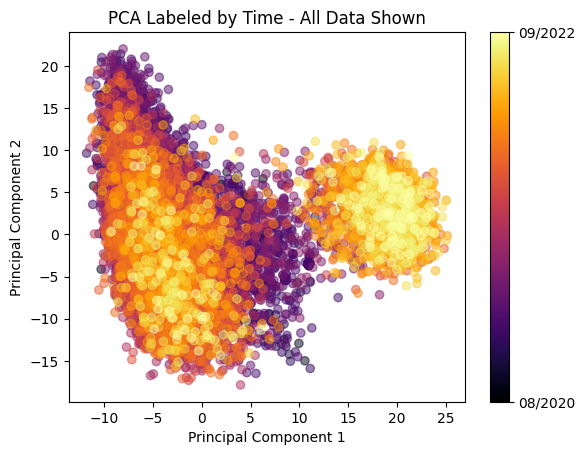

In [46]:
step = 1
plt.scatter(embeddings_pca[::step,0], embeddings_pca[::step,1], c=df_months['color'].to_numpy()[::step], alpha=0.5)
plt.title('PCA Labeled by Time - All Data Shown')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_clim(vmin=0, vmax=100)
hc = plt.colorbar(sm)

hc.set_ticks([0, 100])
hc.set_ticklabels(['08/2020', '09/2022'])

plt.show()

/tmp/ipykernel_18/4132776446.py:8: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  hc = plt.colorbar(sm)


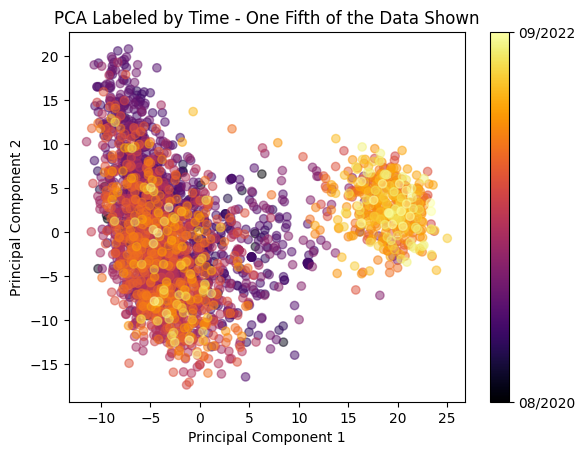

In [47]:
step = 5
plt.scatter(embeddings_pca[::step,0], embeddings_pca[::step,1], c=df_months['color'].to_numpy()[::step], alpha=0.5)
plt.title('PCA Labeled by Time - One Fifth of the Data Shown')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_clim(vmin=0, vmax=100)
hc = plt.colorbar(sm)
hc.set_ticks([0, 100])
hc.set_ticklabels(['08/2020', '09/2022'])

# Looking into the top 10 PCA

In [48]:
# pca = PCA(n_components=10)

# pca.fit(standardized_embeddings)

# embeddings_pca = pca.transform(standardized_embeddings)

# print(pca.explained_variance_ratio_)


Out of the top 10 dimensions, the first two account for 5% and 3% of the total varience (so not much)

In [49]:
usa_data.head()

user_location              date  \
0  united states  18-08-2020 03:14   
1  united states  17-08-2020 17:52   
2  massachusetts  17-08-2020 16:42   
3            usa  16-08-2020 18:22   
4  united states  16-08-2020 01:02   

                                                text  \
0                  ['clear', 'feel', 'covidvaccine']   
1  ['enrolled', 'pivotal', 'phase', 'clinical', '...   
2  ['gern', 'today', 'either', 'going', 'cure', '...   
3  ['silent', 'killer', 'like', 'directedenergywe...   
4      ['bingo', 'card', 'vaccines', 'covidvaccine']   

                                            hashtags  \
0                                   ['covidvaccine']   
1                                   ['CovidVaccine']   
2                                    ['BloodCancer']   
3  ['5G', 'DirectedEnergyWeapons', 'SmartMeter', ...   
4            ['vaccines', 'COVID19', 'CovidVaccine']   

                                            raw_text  date_only  \
0  Just so we’re clear on how I feel about a #cov... 2020-08-18   
1  Just enrolled into a pivotal phase 3 clinical ... 2020-08-17   
2  $GERN up 7% today.... It's either going to cur... 2020-08-17   
3  #5G the silent killer just like #DirectedEnerg... 2020-08-16   
4  Who had this on their 2020 bingo card? #vaccin... 2020-08-16   

                                          clean_text  \
0  just so we’re clear on how i feel about a #cov...   
1  just enrolled into a pivotal phase  clinical t...   
2  $gern up % today.... it's either going to cure...   
3  # the silent killer just like #directedenergyw...   
4  who had this on their  bingo card? #vaccines #...   

                                           embedding               embeddings  \
0  [-0.013506374321877956, -0.04608927294611931, ...  [-0.013506374321877956]   
1  [0.005004002712666988, -0.050803299993276596, ...   [0.005004002712666988]   
2  [0.0024901358410716057, 0.028662126511335373, ...  [0.0024901358410716057]   
3  [0.01767062582075596, 0.03625344857573509, -0....    [0.01767062582075596]   
4  [-0.015944167971611023, -0.030504394322633743,...  [-0.015944167971611023]   

     month                                  embedding_numeric  
0  2020-08  [-0.013506374321877956, -0.04608927294611931, ...  
1  2020-08  [0.005004002712666988, -0.050803299993276596, ...  
2  2020-08  [0.0024901358410716057, 0.028662126511335373, ...  
3  2020-08  [0.01767062582075596, 0.03625344857573509, -0....  
4  2020-08  [-0.015944167971611023, -0.030504394322633743,...

In [50]:
standardized_embeddings

array([[-0.47585466, -0.96513486, -2.50342998, ...,  1.12323677,
         0.01948746,  0.27468898],
       [ 0.27395803, -1.15611343, -0.27237118, ..., -0.03345977,
        -0.41735891, -0.77648026],
       [ 0.17212708,  2.06325566, -0.22185641, ...,  0.23953299,
         0.98377092,  0.75184165],
       ...,
       [ 1.39879355,  0.80628501,  1.56031393, ..., -1.37780203,
         0.71517817, -0.61171506],
       [-0.07568335,  0.84376322,  0.56480782, ..., -0.43348748,
         1.25223299, -1.08106644],
       [-1.6173906 , -1.49451309,  0.26728966, ..., -2.4064767 ,
        -0.5135309 ,  1.76780645]])

In [51]:
embeddings_pca

array([[-9.33601675,  1.51850432],
       [-4.68319625, 10.9381    ],
       [ 0.31656751,  1.99722499],
       ...,
       [ 0.37716681, -9.78392426],
       [-3.26227666, -9.11570617],
       [-3.14897958,  2.82385988]])

# Looking Into The Clusters

In [52]:
# Iterate through each point and check if it falls within the specified range
indices_within_left_range = []
for index, point in enumerate(embeddings_pca):
    x, y = point
    if ((x >= -5) and (x<=-4)) and ((y >= -5) and (y<=-4)):  # Change the condition as needed
        indices_within_left_range.append(index)

# Print the indices of points that fall within the specified range
print("Indices of points within the range:", indices_within_left_range)

Indices of points within the range: [31, 45, 97, 109, 133, 151, 158, 533, 741, 832, 932, 1533, 1852, 2217, 2751, 2807, 2924, 3016, 3417, 3612, 3766, 4359, 4769, 4803, 5216, 5331, 5515, 5668, 5676, 6021, 6162, 6309, 6565, 6613, 6642, 6700, 6769, 6792, 6851, 7126, 7232, 7257, 7353, 7380, 7540, 7564, 7801, 7894, 7906, 8029, 8116, 8340, 8374, 8431, 8589, 8613, 8678, 8818, 8931, 9077, 9117, 9563, 9797, 9873, 10417, 10594, 11237, 11678, 11683, 11914, 12446, 12474, 12492, 12502, 12556, 13243, 13517, 13605, 13871, 14186]


In [53]:
for idx in indices_within_left_range:
    print(usa_data.iloc[idx]['raw_text'])
    print()

Definitely not something you should Putin your body. #RussiaVaccine #COVIDVaccine

https://t.co/7DJzWJC8hk

It's not medically feasible to have a safe #CovidVaccine by November.

.@FoxNews @WhiteHouse I'm a registered nurse. When #DrAnthonyFauci can supervise &amp; administer to every #FoxNews @… https://t.co/YdpJWlpZLE

While we are the first to advocate for universal vaccines, the push to align a #COVIDvaccine on a political timetab… https://t.co/On1EJnMpGp

What not 2 weeks??? @realDonaldTrump  #covidvaccine https://t.co/gws60SI6KS

They’ve taken the risk.... but can their data be trusted?#COVID19 #CovidVaccine #ChinaVirus  https://t.co/DODNWeBepx

Fauci upholds coronavirus vaccine projection timeline https://t.co/GzE5zEbUVo #FoxNews via @FoxNews #vaxnews… https://t.co/gew5BF7X2a

Today I witnessed the most blatant social pressure propaganda. When someone gets the #covid vaccine and is asked to… https://t.co/kj0DhFm1cK

@thehill horseshit, there's plenty of tests and thousands of #C

In [54]:
# Iterate through each point and check if it falls within the specified range
indices_within_right_range = []
for index, point in enumerate(embeddings_pca):
    x, y = point
    if ((x >= 19) and (x<=20)) and ((y >= 2) and (y<=3)):  # Change the condition as needed
        indices_within_right_range.append(index)

# Print the indices of points that fall within the specified range
print("Indices of points within the range:", indices_within_left_range)

Indices of points within the range: [31, 45, 97, 109, 133, 151, 158, 533, 741, 832, 932, 1533, 1852, 2217, 2751, 2807, 2924, 3016, 3417, 3612, 3766, 4359, 4769, 4803, 5216, 5331, 5515, 5668, 5676, 6021, 6162, 6309, 6565, 6613, 6642, 6700, 6769, 6792, 6851, 7126, 7232, 7257, 7353, 7380, 7540, 7564, 7801, 7894, 7906, 8029, 8116, 8340, 8374, 8431, 8589, 8613, 8678, 8818, 8931, 9077, 9117, 9563, 9797, 9873, 10417, 10594, 11237, 11678, 11683, 11914, 12446, 12474, 12492, 12502, 12556, 13243, 13517, 13605, 13871, 14186]


In [55]:
for idx in indices_within_right_range:
    print(usa_data.iloc[idx]['raw_text'])
    print()

No statehood day celebrations owing to pandemic, curfew: Goa CM https://t.co/LRpjfQmWP5 #Mamata #Politics #CovidVaccine #Telangana #IndiaLockdown

Sushant case: Flatmate Pithani arrested, sent to 5 day NCB custody https://t.co/oKqfj5oxQ8 #KCR #coronaviruspandemic #CovidVaccine #Politics #Indiafightscorona

Several TDP leaders in Andhra put under house arrest https://t.co/uPEmNsqudf #Lockdown #ktr #Telangana #CovidVaccine #CovidImpact

HC asks Centre to decide representation on plea for evacuation of Indians, Afghans https://t.co/pPvOUQ2LPY #IndiaCovid #Breakingnews #Tndiapolitics #AndhraPolitics #Aryan #NewsFeed #CovidVaccine #Iphone13 

New Delhi, Oct 27 - The Delhi High Court on Wednesday directed the Cen…

'Sardar Patel Leadership Centre' at Mussoorie dedicated to nation https://t.co/W9MVkLJXvH #RahulGandhi #Breakingnews #Tndiapolitics #AndhraPolitics #Aryan #NewsFeed  #RipAppu #PowerStar #PuneethRajKumar #memes #CovidVaccine 

New Delhi/Mussoorie, Oct 31 - On the occasion of Ra…

H

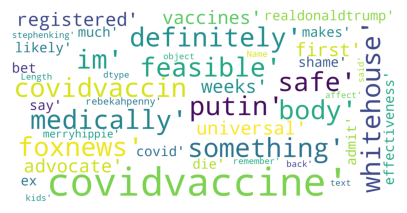

In [56]:
left_cluster = usa_data.iloc[indices_within_left_range]
make_word_cloud(left_cluster)

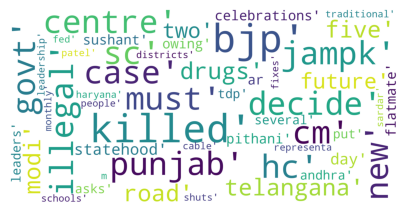

In [57]:
right_cluster = usa_data.iloc[indices_within_right_range]
make_word_cloud(right_cluster)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


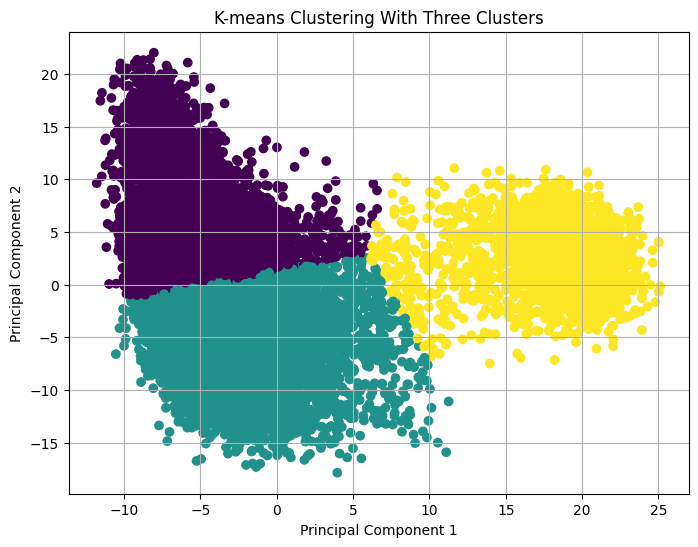

In [58]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(embeddings_pca)

cluster_labels = kmeans.labels_

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title('K-means Clustering With Three Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
# plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()